In [1]:
import numpy as np
from scipy.fft import fft, ifft, fft2, ifft2
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Solve NLS equation, 

$$i u_t = u_{xx} - |u|^2 u,$$ 

with $-15\leq x\leq 15$ and periodic BCs


In [22]:
# Define initial condition
f = lambda x: 2*(1/np.cosh(x+2)) + 1.2*(1/np.cosh(x-3))

L = 30 # Solve for -15 <= x <= 15
n = 128
T = 2
t = np.arange(0,T+0.01,0.01)

x2 = np.linspace(-L/2,L/2,n+1)
x = x2[0:-1]

y0 = f(x)

#Take the FFT of our initial condition
y0hat = fft(y0)

#Scale our k values to the length-L domain
r1=np.arange(0,n/2,1)
r2=np.arange(-n/2,0,1)
k = (2*np.pi/L)*np.concatenate((r1,r2))

In [23]:
def FFT_NLS(t, uhat, k):
    #Convert back to physical space
    u = ifft(uhat)
    #Find the nonlinear term in physical space
    NL_term = u*abs(u)**2
    #return ODE in Fourier domain
    rhs = 1j/2*(k**2)*uhat + 1j*fft(NL_term)
    return rhs

In [24]:
sol = integrate.solve_ivp(lambda t, u: FFT_NLS(t, u, k), [0, T], y0hat, t_eval = t)

In [30]:
y = ifft(sol.y, n=n,axis=0)

#We will plot the modulus squared, which is real
y = abs(y.T)**2


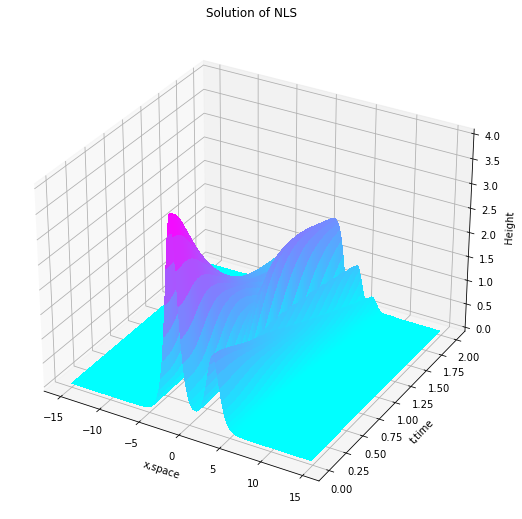

In [55]:
X,T = np.meshgrid(x,t);
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.plot_surface(X,T,y, cmap='cool',linewidth=0, antialiased=False, rcount=200, ccount=200,label='Surface Plot')
ax.set_xlabel('x,space')
ax.set_ylabel('t,time')
ax.set_zlabel('Height')
plt.title('Solution of NLS')
plt.show()

## Solving the vortex dynamics equation with FFT

In [74]:
tspan = np.arange(0,40.5,0.5)
#Define the drag term
nu = 0.001
L=20
n=64
#Setup our x and y domain
x2 = np.linspace(-L/2,L/2,n+1) 
x=x2[0:-1] 
y=x.copy()

#Setup the x values.
r1=np.arange(0,n/2,1)
r2=np.arange(-n/2,0,1)
kx = (2*np.pi/L)*np.concatenate((r1,r2))

#We need to set kx(1) = 10^-6 so that we are not dividing by zero.

kx[0]=10**(-6) 
                                    
ky=kx.copy()

#Put X and Y on a meshgrid
[X,Y]=np.meshgrid(x,y)

#Do the same for the k values
[KX,KY]=np.meshgrid(kx,ky)

#This term shows up in the Laplacian
K = KX**2+KY**2
Kvec = K.reshape(n**2)



In [75]:
#initial conditions - go through the different options to get some cool
# images

winit=np.exp(-2*(X**2)-((Y**2)/20)) # From the notes
#winit = np.exp(-0.25*(X**2)-2*(Y**2))
#winit = -np.exp(-0.25*(X-2)**2-2*Y**2)+np.exp(-0.25*(X+2)**2-2*Y**2)
#winit = -np.exp(-0.25*(X-2)**2-2*(Y+6)**2)+np.exp(-0.25*(X+2)**2-2*(Y+6)**2)
#        +np.exp(-0.25*(X-2)**2-2*(Y-6)**2)-np.exp(-0.25*(X+2)**2-2*(Y-6)**2)
    
# initial conditions in fourier space, vector form
wfinit = fft2(winit)
wfvecinit = wfinit.reshape(n**2)    

In [78]:
def vortrhs(t,wfvec,nu,K,Kvec,n,KX,KY):
    # Reshape the Fourier-transformed vector
    # into an nxn matrix
    wf = wfvec.reshape(n,n)
    
    #Now this is just simple elementwise division.
    psif = -wf/K
    
    #Write all of the terms in the physical space using ifft2.
    psi_x = np.real(ifft2(1j*KX*psif))
    psi_y = np.real(ifft2(1j*KY*psif))
    w_x = np.real(ifft2(1j*KX*wf))
    w_y = np.real(ifft2(1j*KY*wf))

    #Convert everything back and return a vector in the Fourier space.
    rhs = -nu*Kvec*wfvec + fft2(-psi_x*w_y+psi_y*w_x).reshape(n**2)
    return rhs

    

In [92]:
# integrate in fourier space
sol = integrate.solve_ivp(lambda t,wfvec: vortrhs(t,wfvec,nu,K,Kvec,n,KX,KY), [0, 40], wfvecinit, t_eval = tspan)
wfvecsol=sol.y

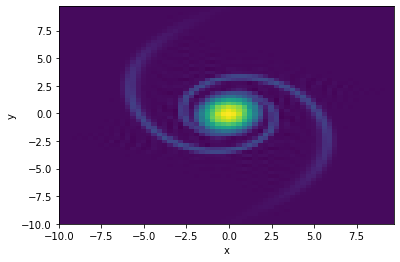

In [99]:
#return to solution space and show as movie
fig = plt.figure()
ax = plt.axes(xlim=(np.min(x), np.max(x)), ylim=(np.min(y), np.max(y)), xlabel='x', ylabel='y')

# animation function
def animate(i):
    global cont
    # Invert the Fourier transform and take the 
    # real part for plotting
    curw=np.real(ifft2(wfvecsol[:,i].reshape(n,n)))
    cont = plt.pcolor(X, Y, curw)
    return cont

anim = animation.FuncAnimation(fig, animate, frames=81, repeat=False)
anim.save('animation.mp4', writer=animation.FFMpegWriter())



## Solve the 1D heat equation with Chebyshev

$$u_t = u_{xx}$$

for $-3\leq x\leq 3$ and Dirichlet BCs


In [2]:
from cheb import *

In [7]:
f = lambda x: np.exp(-x**2)

# We want to solve with 40 interior points. 
N = 40

# Create Chebyshev matrix and Chebyshev grid.
# D is an (N+1)x(N+1) matrix.
[D, x] = cheb(N)
x = x.reshape(N+1)
# Derivative operator squared is second derivative
D2 = D@D

#We want to solve for -3 <= x <= 3, 
#so need to multiply by 4/L^2, L = 6

L = 6

# Rescale x
x = x*L/2

# This rescales the derivative
D2 = 4/(L**2)*D2

# Apply BCs
# Remove the first and last row and column
D2 = D2[1:-1, 1:-1]

# Make sure x changes accordingly too
x2 = x[1:-1]

# Solve up to T = 1
T = 1
t = np.arange(0,T+0.1,0.1)

In [8]:
y0 = f(x2)

In [10]:
# The ODE is straightforward
heat = lambda t,y: 0.5*D2@y

sol = integrate.solve_ivp(heat, [0, T+0.1], y0, t_eval = t)
ysol=sol.y


In [11]:
#We have a solution y, but we need to add back in the BCs
zer = np.zeros(len(t))
ysol = np.vstack((zer,ysol,zer))
ysol = abs(ysol.T)**2

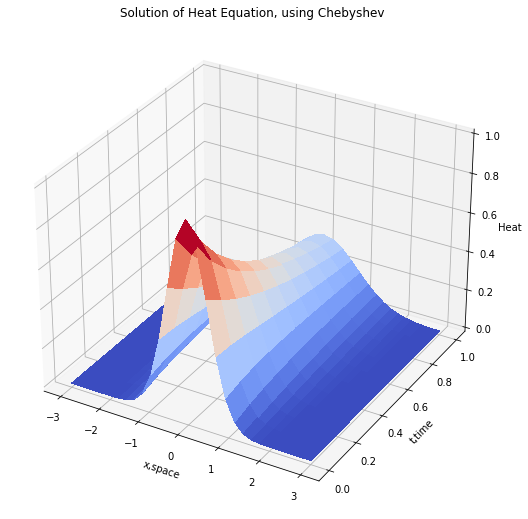

In [13]:
X,T = np.meshgrid(x,t);
fig = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')
ax.plot_surface(X,T,ysol, cmap='coolwarm',linewidth=0, antialiased=False, rcount=200, ccount=200,label='Surface Plot')
ax.set_xlabel('x,space')
ax.set_ylabel('t,time')
ax.set_zlabel('Heat')
plt.title('Solution of Heat Equation, using Chebyshev')
plt.show()

## Solve the 2D heat equation with Chebyshev

$$u_t = u_{xx}+u_{yy}$$

for $-1\leq x\leq 1$ and $-1\leq y\leq 1$ with Dirichlet BCs

In [14]:
# differentiation cheb matrix +b.c.

# We want to solve with 20 interior points. 
N = 20

# Create Chebyshev matrix and Chebyshev grid.
# D is an (N+1)x(N+1) matrix.
[D, x] = cheb(N)
x = x.reshape(N+1)
# Derivative operator squared is second derivative
D2 = D@D

# Apply BCs
# Remove the first and last row and column
D2 = D2[1:-1, 1:-1]

# Make sure x changes accordingly too
x2 = x[1:-1]
y2 = x2.copy()
[X,Y]=np.meshgrid(x2,y2)

tspan = np.arange(0,1+0.05,0.05)

In [15]:
# Explore two different initial conditions.
Uinit = np.exp(-(X**2+Y**2)/0.1);

# Uinit = np.exp(-(X**2+Y**2)/0.1)*np.cos((X-1)*5)*np.cos((Y-1)*5)

#reshape to a vector, for solving
uinitvec = Uinit.reshape((N-1)**2)

In [16]:
I = np.eye(len(D2))

# laplacian matrix. Use "kron" to do that. Don't need to worry so much
# about how it works.
Lap = np.kron(D2,I)+np.kron(I,D2);


In [17]:
def rhs_heat_cheb(t,u,Lap):
    #This is really simple now, just like finite difference
    return Lap@u


In [18]:
sol = integrate.solve_ivp(lambda t,uvec: rhs_heat_cheb(t,uvec,Lap), [0, 1+0.05], uinitvec, t_eval = tspan)
ysol=sol.y

In [19]:
# Create the grid again
y = x.copy()
[X,Y]=np.meshgrid(x,y)

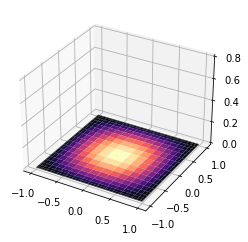

In [20]:
#Plot the solution surface as an animation. 

# animation function
def animate(i):
    plot[0].remove()
    curU=ysol[:,i].reshape(N-1,N-1)
    curU = np.pad(curU,[1,1])
    plot[0] = ax.plot_surface(X, Y, curU,cmap='magma')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
curU=ysol[:,0].reshape(N-1,N-1)
curU = np.pad(curU,[1,1])
plot = [ax.plot_surface(x, y, curU,cmap='magma')]
ax.set_zlim(0, 0.8)


anim = animation.FuncAnimation(fig, animate, frames=21, repeat=False)
anim.save('animation.mp4', writer=animation.FFMpegWriter())


